<a href="https://colab.research.google.com/github/jonzyyyy/AlphaLab/blob/main/AlphaLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup & Libraries

### Setting up necessary keys and env variables
(only required to run at the start of execution)

In [1]:
!pip install python-dotenv --quiet

from google.colab import drive
drive.mount('/content/drive')

# Copy Alpha Lab notebook to folder
!cp "/content/drive/MyDrive/Colab Notebooks/AlphaLab.ipynb" AlphaLab/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file 'AlphaLab/': Not a directory


### GitHub Configurations

In [2]:
!git clone https://github.com/jonzyyyy/AlphaLab.git

Cloning into 'AlphaLab'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 239.78 KiB | 7.05 MiB/s, done.


In [3]:
!pip install yfinance --quiet
!pip install vectorbt --quiet
!pip install streamlit pyngrok --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pyngrok import ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.1 MB/s eta 0:00:00


This block of code below expects a secret that contains the necessary private API keys.

API Keys required:
1. NGROK

In [4]:
# !ngrok config add-authtoken NGROK_API_KEY
from google.colab import userdata
ngrok_token = userdata.get('NGROK_API_KEY')
ngrok.set_auth_token(ngrok_token)

In [5]:
# Parameters
SPLIT_RATIO = 0.7
DATA_YEARS = 2
TOP_N_STOCKS = 5

# 2. Download S&P 500 Stocks List
For simplicity, we'll fetch the tickers from Wikipedia

In [6]:
# Get S&P 500 tickers from Wikipedia
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(sp500_url)
sp500 = sp500_table[0]
tickers = sp500['Symbol'].tolist()

# We'll store market caps in a list of tuples
market_caps = []

for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get('marketCap', None)
        if cap is not None:
            market_caps.append((ticker, cap))
    except Exception as e:
        continue  # skip tickers with issues

# Convert to DataFrame
market_caps_df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])

# Sort by market cap, descending
market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False).reset_index(drop=True)

In [7]:
print(market_caps_df.head(5))  # Show top 5 largest S&P 500 stocks
# (Optional) Use a smaller subset for a fast demo
tickers = market_caps_df['Ticker'][:25].tolist()  # Change to 50 or 100 if you want more
print(tickers)

  Ticker      MarketCap
0   NVDA  4001273741312
1   MSFT  3738716340224
2   AAPL  3115906498560
3   AMZN  2396015296512
4   GOOG  2210008399872
['NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOG', 'GOOGL', 'META', 'AVGO', 'TSLA', 'JPM', 'WMT', 'LLY', 'V', 'ORCL', 'NFLX', 'MA', 'XOM', 'COST', 'JNJ', 'HD', 'PG', 'BAC', 'PLTR', 'ABBV', 'KO']


In [8]:
# =======================
# 3. Download Price Data
# =======================
end = datetime.today()
start = end - timedelta(days=365*DATA_YEARS)  # Last 2 years
price_data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, progress=False)
print(price_data.head(3))

Ticker            GOOG                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2023-07-17  125.315113  126.527905  123.764333  124.321022  20675300   
2023-07-18  124.166931  124.251428  122.571420  123.346809  21071200   
2023-07-19  124.052614  124.728596  121.746323  122.054489  22313800   

Ticker              HD                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2023-07-17  300.388888  302.386919  298.895119  300.702850  2002500  ...   
2023-07-18  299.256725  302.862694  296.973272  301.378448  2317000  ...   
2023-07-19  301.606755  304.403994  301.311811  303.966339  2361400  ...   

Ticker            COST                                               \
Price             Open        High     

In [9]:
# =======================
# 4. Train-Test Split
# =======================
all_dates = price_data[tickers[0]]['Close'].index
split_idx = int(len(all_dates) * SPLIT_RATIO)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

# Helper function to get price for a given ticker and period
def get_close_prices(ticker, dates):
    try:
        close = price_data[ticker]['Close'].reindex(dates)
        return close
    except:
        return pd.Series(index=dates, dtype=float)

In [10]:
# =======================
# 5. Factor Calculation (Value, Momentum)
# =======================
factor_df = pd.DataFrame(index=tickers)

# Value factor: Trailing P/E (lower is "better")
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        factor_df.loc[ticker, 'pe_ratio'] = info.get('trailingPE', np.nan)
    except Exception:
        factor_df.loc[ticker, 'pe_ratio'] = np.nan

# Momentum factor: 6-month price return
for ticker in tickers:
    try:
        prices = price_data[ticker]['Close'].dropna()
        if len(prices) > 126:
            factor_df.loc[ticker, '6m_return'] = (prices.iloc[-1] / prices.iloc[-126]) - 1
        else:
            factor_df.loc[ticker, '6m_return'] = np.nan
    except Exception:
        factor_df.loc[ticker, '6m_return'] = np.nan

# Drop rows with missing factors
factor_df = factor_df.dropna()
print(factor_df.head(20))

         pe_ratio  6m_return
NVDA    52.925810   0.207391
MSFT    38.903324   0.205284
AAPL    32.444790  -0.117065
AMZN    36.757330   0.030830
GOOG    20.402900  -0.051415
GOOGL   20.240800  -0.052337
META    28.171942   0.172534
AVGO   100.952385   0.235275
TSLA   182.126430  -0.197193
JPM     14.165850   0.216816
WMT     40.931625   0.035218
LLY     64.934200   0.003074
V       35.226130   0.142871
ORCL    52.951500   0.492508
NFLX    59.525940   0.506464
MA      38.754030   0.099028
XOM     15.108753   0.088770
COST    55.544167   0.049452
JNJ     17.443829   0.122276
HD      25.126272  -0.038771


In [11]:
# =======================
# 6. Composite Scoring & Stock Selection
# =======================
# Rank: lower P/E is better, higher momentum is better
factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending=True)
factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False)
# Simple equal-weight composite score
factor_df['composite_score'] = (factor_df['pe_rank'] + factor_df['mom_rank']) / 2

# Select top N stocks
selected = factor_df.nsmallest(TOP_N_STOCKS, 'composite_score')
selected_tickers = selected.index.tolist()
print("Selected stocks for backtest:", selected_tickers)

Selected stocks for backtest: ['JPM', 'JNJ', 'BAC', 'XOM', 'META']


In [43]:
# =======================
# 7. Backtesting (Quarterly Rebalancing)
# =======================

# Filter price data for selected tickers and train/test periods
selected_prices_train = price_data[selected_tickers].reindex(train_dates)
selected_prices_test = price_data[selected_tickers].reindex(test_dates)

# 1. Find all trading days in your price data
all_dates = selected_prices_test.index

# 2. Set target rebalance dates (e.g., quarterly)
rebalance_targets = pd.date_range(start=all_dates[0], end=all_dates[-1], freq='QS')

# 3. Map each target rebalance date to the nearest available trading day ON OR AFTER the target
mapped_rebalance_dates = []
for target in rebalance_targets:
    candidates = all_dates[all_dates >= target]
    if not candidates.empty:
        mapped_rebalance_dates.append(candidates[0])
# Always include the very first day if it's not already in the list
if all_dates[0] not in mapped_rebalance_dates:
    mapped_rebalance_dates = [all_dates[0]] + mapped_rebalance_dates

print("Final mapped rebalance dates:", mapped_rebalance_dates)

# 4. Assign weights on these mapped rebalance dates
portfolio = pd.DataFrame(1 / len(selected_prices_test.columns), index=all_dates, columns=selected_prices_test.columns)
# print(portfolio.head(20))

# 5. Returns and cumulative returns
returns = selected_prices_test.pct_change().fillna(0)

# Recalculate portfolio returns by applying weights only to 'Close' returns
# Select only the 'Close' returns for the selected tickers
close_returns_only = returns.loc[:, (selected_tickers, 'Close')]

# Select only the 'Close' weights for the selected tickers
portfolio_close_weights = portfolio.loc[:, (selected_tickers, 'Close')]

# Calculate portfolio returns by multiplying close returns with close weights and summing across tickers
portfolio_returns_corrected = (close_returns_only * portfolio_close_weights).sum(axis=1)

# Update the cum_returns as well since the original portfolio_returns was incorrect
cum_returns_corrected = (1 + portfolio_returns_corrected).cumprod()

# Rename the corrected variables to match the original variable names for consistency in subsequent cells
portfolio_returns = portfolio_returns_corrected
cum_returns = cum_returns_corrected

print(portfolio_returns.head())
# print(portfolio_returns.head(20))

Final mapped rebalance dates: [Timestamp('2024-12-04 00:00:00'), Timestamp('2025-01-02 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-07-01 00:00:00')]
Date
2024-12-04    0.000000
2024-12-05    0.000492
2024-12-06    0.000812
2024-12-09   -0.002105
2024-12-10   -0.000101
dtype: float64


<Figure size 1200x600 with 0 Axes>

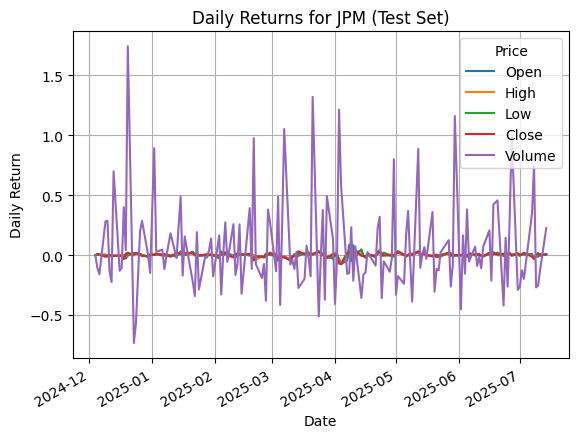

<Figure size 1200x600 with 0 Axes>

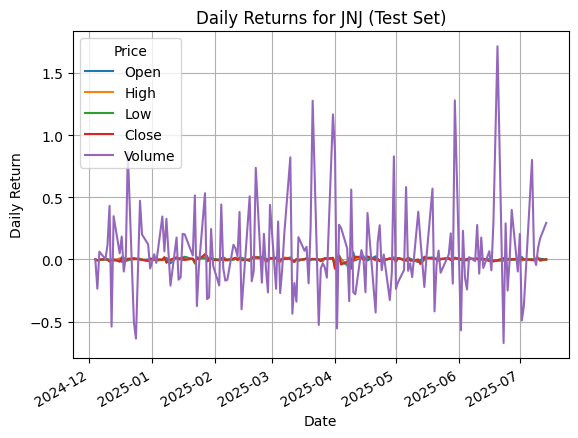

<Figure size 1200x600 with 0 Axes>

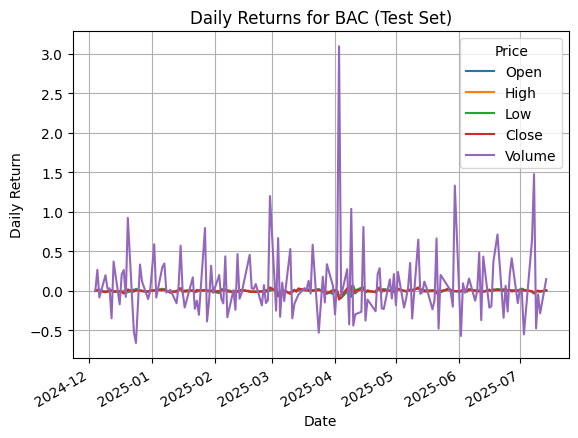

<Figure size 1200x600 with 0 Axes>

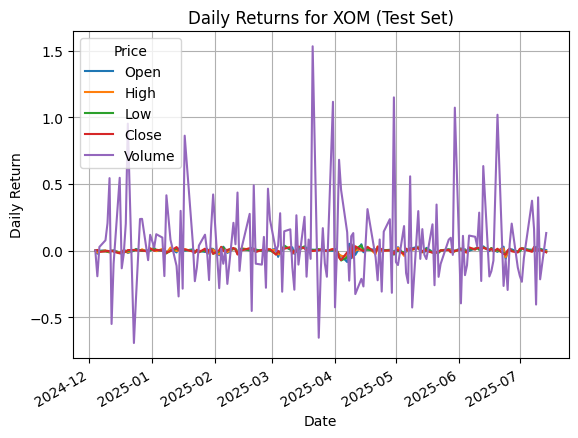

<Figure size 1200x600 with 0 Axes>

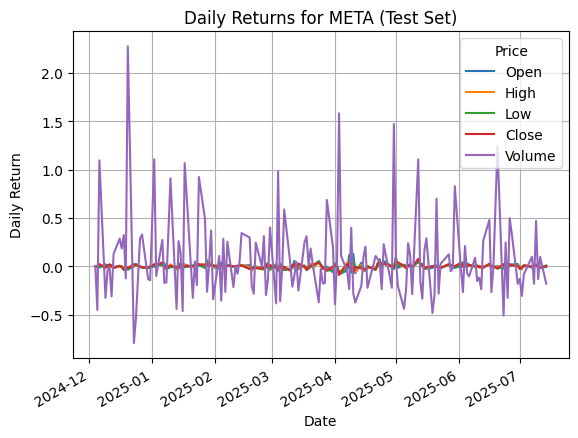

In [47]:
# =======================
# 8a. Results Visualization
# =======================
# Plot daily returns for each selected stock
for ticker in selected_tickers:
    plt.figure(figsize=(12, 6))
    returns[ticker].plot()
    plt.title(f'Daily Returns for {ticker} (Test Set)')
    plt.ylabel('Daily Return')
    plt.xlabel('Date')
    plt.grid()
    plt.show()

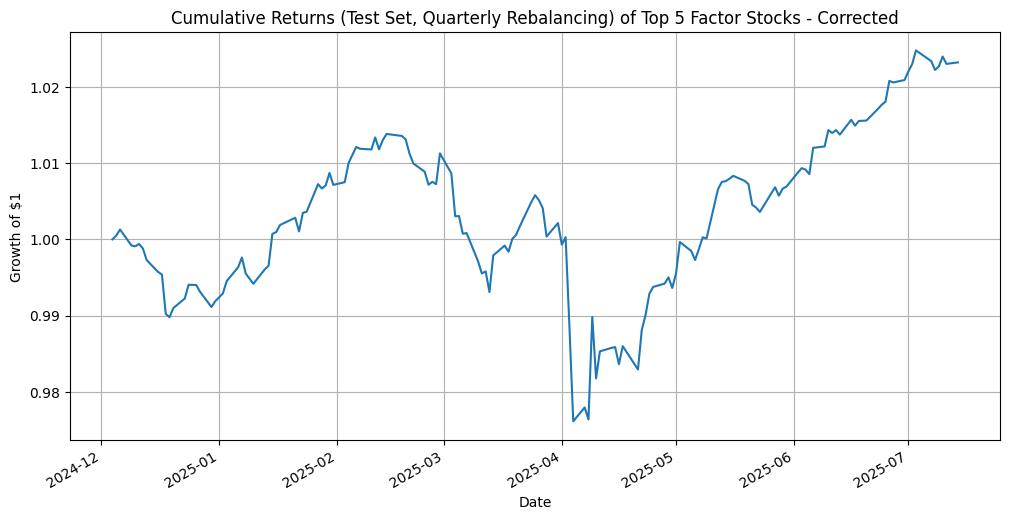

In [48]:
# =======================
# 8b. cum_returns Results Visualization
# =======================
plt.figure(figsize=(12,6))
cum_returns.plot() # Use the corrected cum_returns
plt.title('Cumulative Returns (Test Set, Quarterly Rebalancing) of Top 5 Factor Stocks - Corrected') # Update title
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.grid()
plt.show()

In [49]:
# =======================
# 9. Simple Performance Stats
# =======================
total_return = cum_returns.iloc[-1] - 1
annualized_return = cum_returns.iloc[-1]**(252/len(cum_returns)) - 1
annualized_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = annualized_return / annualized_vol

print(f"Last value of cumulative returns: {cum_returns.iloc[-1]:.2f}")
print(f"Total Return (Test): {total_return:.2%}")
print(f"Annualized Return (Test): {annualized_return:.2%}")
print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
print(f"Sharpe Ratio (Test): {sharpe:.2f}")

Last value of cumulative returns: 1.02
Total Return (Test): 2.33%
Annualized Return (Test): 3.94%
Annualized Volatility (Test): 4.24%
Sharpe Ratio (Test): 0.93


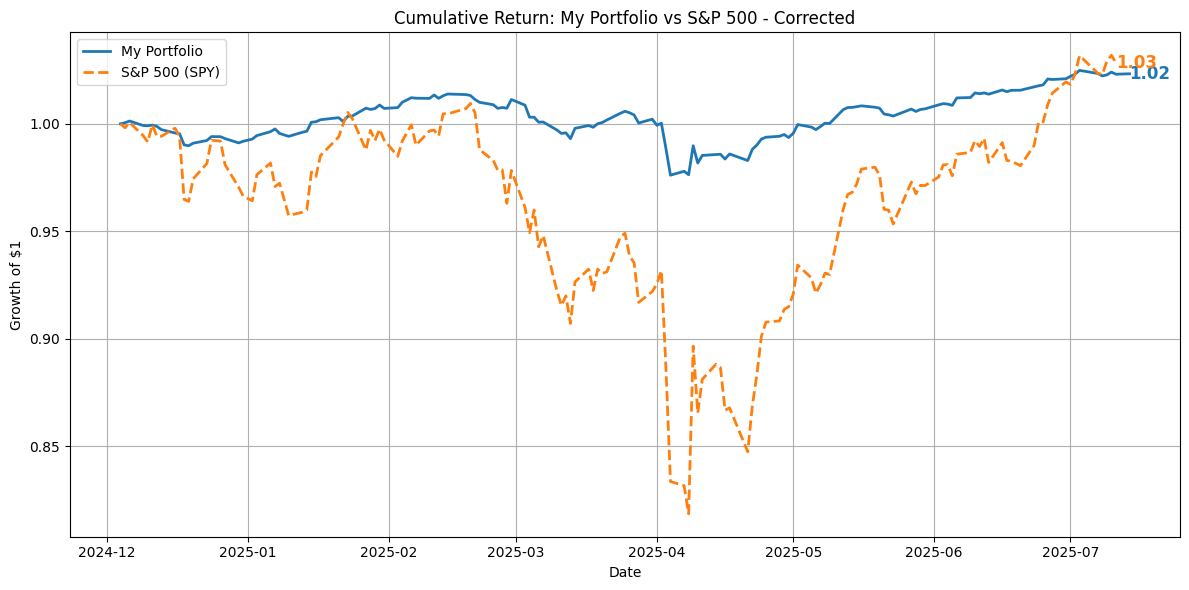

In [50]:
# =======================
# 8. Results Visualization (with Benchmark)
# =======================

# 1. Download S&P 500 (SPY) data for the test period
spy_ticker = '^GSPC' # or 'SPY' for the ETF
spy_data = yf.download(spy_ticker, start=test_dates[0], end=test_dates[-1], auto_adjust=True, progress=False)
spy_close_prices = spy_data['Close']

# 2. Calculate SPY's daily returns and cumulative returns
benchmark_returns = spy_close_prices.pct_change().fillna(0)
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Align the two time series to a common index
common_index = cum_returns.index.union(benchmark_cum_returns.index)
cum_returns_aligned = cum_returns.reindex(common_index)
benchmark_cum_returns_aligned = benchmark_cum_returns.reindex(common_index)


# 3. Plot both on the same graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot your portfolio
plt.plot(cum_returns_aligned.index, cum_returns_aligned.values,
         label='My Portfolio', linewidth=2)

# Plot the benchmark
plt.plot(benchmark_cum_returns_aligned.index, benchmark_cum_returns_aligned.values,
         linestyle='--', label='S&P 500 (SPY)', linewidth=2)

# Annotate final values
last_portfolio_date = cum_returns_aligned.dropna().index[-1]
last_portfolio_value = cum_returns_aligned.dropna().iloc[-1]

last_benchmark_date = benchmark_cum_returns_aligned.dropna().index[-1]
last_benchmark_value = benchmark_cum_returns_aligned.dropna().iloc[-1].iloc[0] # Access the scalar value


plt.text(last_portfolio_date, last_portfolio_value,
         f"{last_portfolio_value:.2f}",
         color='C0', fontsize=12, va='center', ha='left', fontweight='bold')

plt.text(last_benchmark_date, last_benchmark_value,
         f"{last_benchmark_value:.2f}",
         color='C1', fontsize=12, va='center', ha='left', fontweight='bold')

plt.title('Cumulative Return: My Portfolio vs S&P 500 - Corrected') # Update title
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Deploys the pipeline on a easy to use interface

In [51]:
# Write a simple Streamlit app
with open('app.py', 'w') as f:
    f.write("""m
st.write('It works in Colab!')
""")

# Open the tunnel
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

# Run Streamlit
!streamlit run app.py &>/dev/null&

Public URL: NgrokTunnel: "https://f660092cdc94.ngrok-free.app" -> "http://localhost:8501"
